In [ ]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from itertools import chain
import nltk
from scipy import stats

# Loading dataset

In [ ]:
if os.path.exists("../datasets/dataset.csv"):
    df = pd.read_csv("../datasets/dataset.csv")
else:
    print("Dataset not found. Please ensure the dataset is located at '../datasets/dataset.csv'.")

In [ ]:
df.columns

In [ ]:
df.info()

In [ ]:
df.describe(include='all')

In [ ]:
df.nunique().sort_values(ascending=False)

In [ ]:
df.head()

# Check for duplicates and missing values

## Check for missing values

In [ ]:
df.isnull().sum()

tweet_id               0
gender_label           0
text                   0
user_id                0
retweeted_id      169668
quoted_id         265844
in_reply_to_id    282049
dtype: int64

In [ ]:
df[df.isna().any(axis=1)]

,tweet_id,gender_label,text,user_id,retweeted_id,quoted_id,in_reply_to_id
0,1367014748877967361,M,Help us dig deeper…\n\nThe @GoodLawProject int...,237903632,1.365606e+18,1.365594e+18,NaN
1,1367014749075091456,M,A survey of Austrians found that 65% of the co...,885706429679771649,1.366765e+18,NaN,NaN
2,1367014749632880643,F,"@CynBlogger @BetoORourke @brat2381 Abbott, Par...",2337152816,1.366901e+18,NaN,NaN
3,1367014750492762114,M,We are excited about the reduction of #COVID19...,754615120110710784,1.366996e+18,NaN,NaN
4,1367014750920400896,F,@GemmaLeeJones @JohnDesMarteau @itsJeffTiedric...,785984135139627008,NaN,NaN,1.366843e+18
...,...,...,...,...,...,...,...
306133,1367116617851756548,F,@rbc2222 @KimStrassel @WSJ Trump oversaw getti...,241211717,NaN,NaN,1.366925e+18
306134,1367116618841559051,M,@IGNOUHelp_in @OfficialIGNOU @IgnouZone @Ignou...,761017787582033920,NaN,NaN,NaN
306135,1367116619277684746,M,"Unlike usual protocol, most major COVID19 vacc...",2274521738,1.367084e+18,1.367080e+18,NaN
306136,1367116619437195267,F,(3/5) The emails between Jonas Ludvigsson and ...,439321373,1.367102e+18,1.367052e+18,NaN


In [ ]:
df['user_id'].value_counts().sort_values(ascending=False)

user_id
569771794              90548
1427376980             13116
1331229380102811648      196
453925983                150
23730132                  87
                       ...  
454932645                  1
250795544                  1
3297317837                 1
1092260347996708867        1
417257017                  1
Name: count, Length: 124309, dtype: int64

## Drop empty

In [ ]:
df = df.dropna(subset='text',inplace=False).reset_index(drop=True)

## Check for duplicates

In [ ]:
df.duplicated().sum()

np.int64(105945)

In [ ]:
df[df.duplicated()]

,tweet_id,gender_label,text,user_id,retweeted_id,quoted_id,in_reply_to_id
107437,1367078005579730944,M,It is possible that the effects of vaccination...,897432913,NaN,NaN,1.367078e+18
107439,1367078005642723336,M,India’s TOP 1000 private companies should cove...,4385654592,1.367069e+18,NaN,NaN
107441,1367078005659598850,M,Instead of voting to help millions impacted by...,4181663718,1.366969e+18,NaN,NaN
107443,1367078006838099971,M,NEW IN EUROPEAN SCIENTIST \n\nPoor diet is roo...,997970180784340993,1.251024e+18,NaN,NaN
107445,1367078007211495424,F,📅 Juventus will play Napoli on March 17 after ...,275554600,1.367070e+18,NaN,NaN
...,...,...,...,...,...,...,...
286155,1367108916497235970,F,A year ago today @BorisJohnson boasted about v...,20383769,1.367052e+18,NaN,NaN
286157,1367108917092843521,M,78 million COVID vaccine doses have been admin...,293093798,1.366943e+18,NaN,NaN
286159,1367108917164183552,F,"""It's amazing,"" Paul Gosar's old Tea Party pal...",22951187,1.367104e+18,NaN,NaN
286161,1367108917482905601,F,Yesterday evening I received my Covid-19 vacci...,162605421,1.366761e+18,NaN,NaN


## Drop duplicates

In [ ]:
df = df.drop_duplicates(inplace=False, keep='first').reset_index(drop=True)

after cleaning dataset we have this amount of rows

In [ ]:
df.shape

(200193, 7)

# Extracting data from text

## Tokenization for lexical diversity

### Create clean tokens function

In [ ]:
def create_clean_tokens(text: str, stop_words: list[str] = ENGLISH_STOP_WORDS, topic_words: list[str] = []) -> str|None:
    if not text:
        return None
    
    text = text.lower().strip()
    
    if text.startswith('@'):
        return None
    if text.startswith('#'):
        return None
    if text.startswith('&'):
        return None
    if text.startswith('http'):
        return None

    if text.isdigit():
        return None
    if len(text) < 2:
        return None
    
    text = re.sub(r"[^a-z]", "", text)
    if text.startswith('@'):
        return None
    if text.startswith('#'):
        return None
    if text.startswith('&'):
        return None
    if text.startswith('http'):
        return None
    
    if text in stop_words:
        return None
    if text in topic_words:
        return None

    return text

def tokenize_clear(text: str, topic_words: list[str] = []) -> list[str]:
    if not isinstance(text, str):
        return []

    words = text.split()
    cleaned = [create_clean_tokens(w, topic_words=topic_words) for w in words]
    return [w for w in cleaned if w]

### Create clean tokens

In [ ]:
df['clean_tokens'] = df['text'].apply(tokenize_clear, args=(['vaccine','covid','pandemic', 'vaccines', 'vaccination', 'virus', 'vaccinated', 'coronavirus'],))

In [ ]:
df.head()

,tweet_id,gender_label,text,user_id,retweeted_id,quoted_id,in_reply_to_id,clean_tokens
0,1367014748877967361,M,Help us dig deeper…\n\nThe @GoodLawProject int...,237903632,1.365606e+18,1.365594e+18,NaN,"[help, dig, deeper, intends, investigate, cont..."
1,1367014749075091456,M,A survey of Austrians found that 65% of the co...,885706429679771649,1.366765e+18,NaN,NaN,"[survey, austrians, country, feels, restrictio..."
2,1367014749632880643,F,"@CynBlogger @BetoORourke @brat2381 Abbott, Par...",2337152816,1.366901e+18,NaN,NaN,"[abbott, parson, desantis, trump, prison, pand..."
3,1367014750492762114,M,We are excited about the reduction of #COVID19...,754615120110710784,1.366996e+18,NaN,NaN,"[excited, reduction, cases, make, relaxvaccine..."
4,1367014750920400896,F,@GemmaLeeJones @JohnDesMarteau @itsJeffTiedric...,785984135139627008,NaN,NaN,1.366843e+18,"[huffingamppuffing, climbed, stairs, balcony, ..."


### drop similar rows based on clean tokens

In [ ]:
df['joined_tokens'] = df['clean_tokens'].apply(lambda x: ''.join(x) if x else '')
duplicate_count = df['joined_tokens'].duplicated().sum()
print(f"Number of duplicate messages (based on clean tokens): {duplicate_count}")
df['joined_tokens'].value_counts().sort_values(ascending=False)

Number of duplicate messages (based on clean tokens): 116440


joined_tokens
horrifictotallyunnecessarytreatmentincapacitatedprotester                                                                                    2275
yearagotodayfinallyattendingcobrawarnedseriousnessborisjohnsonsaidimshakinghandscontinuouslyhospitalnightthinkpatientsshookhandseverybody    1522
havinggovernordecidecompletelyreopentexaslikehavingbunchmillionairesenatorsdecidedontneedhrharmcausejustwontaffect                            952
weeksagoannouncedsupplyamericansendjulyeffortsrampproductionamericanend                                                                       833
sickhearingaffordreliefexactpeoplepassedtaxcutcorporationssuperrich                                                                           826
                                                                                                                                             ... 
waaromdoendatnleigenlijknietrttodaydirectingstateprioritizeeducatorswanteducatorschoolstaffmem                

In [ ]:
df.drop_duplicates(subset='joined_tokens', inplace=True, keep='first')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83753 entries, 0 to 200189
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        83753 non-null  object 
 1   gender_label    83753 non-null  object 
 2   text            83753 non-null  object 
 3   user_id         83753 non-null  object 
 4   retweeted_id    25080 non-null  float64
 5   quoted_id       19367 non-null  float64
 6   in_reply_to_id  22416 non-null  float64
 7   clean_tokens    83753 non-null  object 
 8   joined_tokens   83753 non-null  object 
dtypes: float64(3), object(6)
memory usage: 6.4+ MB


### Create dirty tokens function

In [ ]:
from math import e


emoji_re = re.compile("["
                        u"\U0001F600-\U0001F64F"   
                        u"\U0001F300-\U0001F5FF"
                        u"\U0001F680-\U0001F6FF"
                        u"\U0001F1E0-\U0001F1FF"
                        u"\U00002702-\U000027B0"  
                        u"\U000024C2-\U0001F251"
                        "]", flags=re.UNICODE)
emoji_unique = set(chain.from_iterable(df['text'].str.findall(emoji_re)))
len(emoji_unique), emoji_unique

(1133,
 {'⛽',
  '🌞',
  '⛔',
  '⛱',
  'た',
  '💍',
  '💧',
  '💶',
  '▶',
  'ｳ',
  'ご',
  '𝐂',
  '▸',
  '🏝',
  '☘',
  '𝘣',
  '😭',
  '✈',
  '👋',
  'リ',
  '➤',
  'と',
  '👒',
  '🐳',
  '⛸',
  '🎪',
  '🙇',
  '🛌',
  '📍',
  '👑',
  '🕛',
  '🇼',
  '🏥',
  '들',
  '🚪',
  '𝐘',
  'す',
  '😝',
  '🚙',
  '🚎',
  '✋',
  '🚃',
  '니',
  '씽',
  '🕔',
  '💁',
  '👶',
  '🐘',
  '𝐫',
  '！',
  'ア',
  '👻',
  'フ',
  '📉',
  '𝘿',
  '🙂',
  '🍍',
  '🍘',
  '𝒆',
  '⛹',
  '🗿',
  '🔼',
  '🇪',
  '𝘼',
  '😣',
  '😫',
  '🎲',
  '🎮',
  '💠',
  '🎀',
  '𝗼',
  '🇳',
  '🍳',
  '버',
  '𝗳',
  '📂',
  '📑',
  '💈',
  '➣',
  '🐇',
  '라',
  '🍫',
  '🎰',
  '☹',
  '🐄',
  '리',
  '🌾',
  '🏖',
  '🍿',
  '⠀',
  '❤',
  '。',
  '🍅',
  '베',
  '✂',
  '😡',
  '➦',
  '𝙊',
  '🇾',
  '🍄',
  '𝘱',
  '𝟑',
  '👩',
  '📎',
  '➜',
  '🙆',
  '🚡',
  '👐',
  '☆',
  '🗒',
  '찾',
  '★',
  '😛',
  '❓',
  '苹',
  '料',
  '🎛',
  '🌡',
  '🎁',
  '💦',
  '🇦',
  '👔',
  '𝗝',
  '🐊',
  '👃',
  '🆓',
  '🍌',
  '✊',
  '👄',
  '🖐',
  '✌',
  '👎',
  '🃏',
  '🏆',
  '😈',
  '𝕤',
  '南',
  '📴',
  '👈',
  '📢',
  '🚂',
  '🏨',

In [ ]:
emoji_enum = {emoji: f"emoji_{idx}" for idx, emoji in enumerate(emoji_unique)}
emoji_enum

{'⛽': 'emoji_0',
 '🌞': 'emoji_1',
 '⛔': 'emoji_2',
 '⛱': 'emoji_3',
 'た': 'emoji_4',
 '💍': 'emoji_5',
 '💧': 'emoji_6',
 '💶': 'emoji_7',
 '▶': 'emoji_8',
 'ｳ': 'emoji_9',
 'ご': 'emoji_10',
 '𝐂': 'emoji_11',
 '▸': 'emoji_12',
 '🏝': 'emoji_13',
 '☘': 'emoji_14',
 '𝘣': 'emoji_15',
 '😭': 'emoji_16',
 '✈': 'emoji_17',
 '👋': 'emoji_18',
 'リ': 'emoji_19',
 '➤': 'emoji_20',
 'と': 'emoji_21',
 '👒': 'emoji_22',
 '🐳': 'emoji_23',
 '⛸': 'emoji_24',
 '🎪': 'emoji_25',
 '🙇': 'emoji_26',
 '🛌': 'emoji_27',
 '📍': 'emoji_28',
 '👑': 'emoji_29',
 '🕛': 'emoji_30',
 '🇼': 'emoji_31',
 '🏥': 'emoji_32',
 '들': 'emoji_33',
 '🚪': 'emoji_34',
 '𝐘': 'emoji_35',
 'す': 'emoji_36',
 '😝': 'emoji_37',
 '🚙': 'emoji_38',
 '🚎': 'emoji_39',
 '✋': 'emoji_40',
 '🚃': 'emoji_41',
 '니': 'emoji_42',
 '씽': 'emoji_43',
 '🕔': 'emoji_44',
 '💁': 'emoji_45',
 '👶': 'emoji_46',
 '🐘': 'emoji_47',
 '𝐫': 'emoji_48',
 '！': 'emoji_49',
 'ア': 'emoji_50',
 '👻': 'emoji_51',
 'フ': 'emoji_52',
 '📉': 'emoji_53',
 '𝘿': 'emoji_54',
 '🙂': 'emoji_55',
 '

In [ ]:
def create_dirty_tokens(text: str, topic_words: list[str] = []):
    emoji_re = re.compile("["
                        u"\U0001F600-\U0001F64F"   
                        u"\U0001F300-\U0001F5FF"
                        u"\U0001F680-\U0001F6FF"
                        u"\U0001F1E0-\U0001F1FF"
                        u"\U00002702-\U000027B0"  
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
    
    tokens: list[str] = text.split()
    filtered =  []
    for token in tokens:
        if token.lower() in topic_words:
            continue
        if token.strip().lower() in topic_words:
            continue
        emoji_match = emoji_re.search(token)
        if emoji_match:
            emoji_char = emoji_match.group()
            token = token.replace(emoji_char, emoji_enum.get(emoji_char, emoji_char))

        token = token.replace(' ', '_')
        found = False
        for item in topic_words:
            if token.lower().find(item) != -1:
                found = True
                break
        if found:
            continue

        if token in {'http','https','co','t','amp','gt','rt'}:
            continue
        for item in {'http','https','co','t','amp','gt','rt'}:
            if token.lower().find(item) != -1:
                found = True
                break
        if found:
            continue

        filtered.append(token)

    return filtered

### Create dirty tokens

In [ ]:
topic_words = ['vaccine','covid','pandemic', 'vaccines', 'vaccination', 'virus', 'vaccinated', 'coronavirus', '19', 'covid']

In [ ]:
df['dirty_tokens'] = df['text'].apply(lambda x: create_dirty_tokens(x, topic_words=topic_words))

In [ ]:
df.head()

,tweet_id,gender_label,text,user_id,retweeted_id,quoted_id,in_reply_to_id,clean_tokens,joined_tokens,dirty_tokens
0,1367014748877967361,M,Help us dig deeper…\n\nThe @GoodLawProject int...,237903632,1.365606e+18,1.365594e+18,NaN,"[help, dig, deeper, intends, investigate, cont...",helpdigdeeperintendsinvestigatecontractsctmawa...,"[Help, us, dig, deeper…, how, were, awarded., ..."
1,1367014749075091456,M,A survey of Austrians found that 65% of the co...,885706429679771649,1.366765e+18,NaN,NaN,"[survey, austrians, country, feels, restrictio...",surveyaustrianscountryfeelsrestrictionsworseau...,"[A, survey, of, found, 65%, of, feels, are, wo..."
2,1367014749632880643,F,"@CynBlogger @BetoORourke @brat2381 Abbott, Par...",2337152816,1.366901e+18,NaN,NaN,"[abbott, parson, desantis, trump, prison, pand...",abbottparsondesantistrumpprisonpandemicidewilf...,"[@CynBlogger, Parson,, and, should, be, in, pr..."
3,1367014750492762114,M,We are excited about the reduction of #COVID19...,754615120110710784,1.366996e+18,NaN,NaN,"[excited, reduction, cases, make, relaxvaccine...",excitedreductioncasesmakerelaxvaccinespreventi...,"[We, are, of, cases., however, can, make, us, ..."
4,1367014750920400896,F,@GemmaLeeJones @JohnDesMarteau @itsJeffTiedric...,785984135139627008,NaN,NaN,1.366843e+18,"[huffingamppuffing, climbed, stairs, balcony, ...",huffingamppuffingclimbedstairsbalconybelieveim...,"[@GemmaLeeJones, He, was, because, he, climbed..."


## Lenght

### Length of text

In [ ]:
df['char_len'] = df['text'].apply(len)

In [ ]:
df.head()

,tweet_id,gender_label,text,user_id,retweeted_id,quoted_id,in_reply_to_id,clean_tokens,joined_tokens,dirty_tokens,char_len
0,1367014748877967361,M,Help us dig deeper…\n\nThe @GoodLawProject int...,237903632,1.365606e+18,1.365594e+18,NaN,"[help, dig, deeper, intends, investigate, cont...",helpdigdeeperintendsinvestigatecontractsctmawa...,"[Help, us, dig, deeper…, how, were, awarded., ...",207
1,1367014749075091456,M,A survey of Austrians found that 65% of the co...,885706429679771649,1.366765e+18,NaN,NaN,"[survey, austrians, country, feels, restrictio...",surveyaustrianscountryfeelsrestrictionsworseau...,"[A, survey, of, found, 65%, of, feels, are, wo...",279
2,1367014749632880643,F,"@CynBlogger @BetoORourke @brat2381 Abbott, Par...",2337152816,1.366901e+18,NaN,NaN,"[abbott, parson, desantis, trump, prison, pand...",abbottparsondesantistrumpprisonpandemicidewilf...,"[@CynBlogger, Parson,, and, should, be, in, pr...",259
3,1367014750492762114,M,We are excited about the reduction of #COVID19...,754615120110710784,1.366996e+18,NaN,NaN,"[excited, reduction, cases, make, relaxvaccine...",excitedreductioncasesmakerelaxvaccinespreventi...,"[We, are, of, cases., however, can, make, us, ...",236
4,1367014750920400896,F,@GemmaLeeJones @JohnDesMarteau @itsJeffTiedric...,785984135139627008,NaN,NaN,1.366843e+18,"[huffingamppuffing, climbed, stairs, balcony, ...",huffingamppuffingclimbedstairsbalconybelieveim...,"[@GemmaLeeJones, He, was, because, he, climbed...",242


check how many tokens have less then 20 chars

In [ ]:
df[df['char_len'] <= 20].head(10).sort_values(by='char_len', ascending=True)

,tweet_id,gender_label,text,user_id,retweeted_id,quoted_id,in_reply_to_id,clean_tokens,joined_tokens,dirty_tokens,char_len
129,1367014830012465152,F,Me too.,1285382253590179841,NaN,1.366735e+18,NaN,[],,[Me],7
392,1367014982785769473,M,Accurate,315281750,NaN,1.366943e+18,NaN,[accurate],accurate,[],8
553,1367015074859261954,M,Preach! 🌍,413486466,NaN,1.366995e+18,NaN,[preach],preach,"[Preach!, emoji_1049]",9
962,1367015310604132357,M,Plz help 🙏,1174346283328233472,1.366969e+18,1.337412e+18,NaN,"[plz, help]",plzhelp,"[Plz, help]",10
45,1367014782637920263,F,Heartbreaking,2311116235,NaN,1.366793e+18,NaN,[heartbreaking],heartbreaking,[],13
116,1367014822110523394,F,Listen to Dolly!,2872545370,NaN,1.367003e+18,NaN,"[listen, dolly]",listendolly,[Dolly!],16
661,1367015141762625536,F,This is amazing!,634572583,NaN,1.366720e+18,NaN,[amazing],amazing,"[is, amazing!]",16
485,1367015033104830465,M,Long-COVID Thread:,138649369,NaN,1.343294e+18,NaN,"[longcovid, thread]",longcovidthread,[],18
475,1367015025928531973,M,Me duele Baleares.,407628600,NaN,1.366997e+18,NaN,"[duele, baleares]",duelebaleares,"[Me, duele, Baleares.]",18
973,1367015317604425732,M,You bet!! @POTUS @VP,1213894397953069056,NaN,1.366942e+18,NaN,[bet],bet,"[You, @VP]",20


In [ ]:
df[df['char_len'] <= 20]['char_len'].count()

np.int64(1235)

### Clean tokens count

In [ ]:
df['tokens_count_clean'] = df['clean_tokens'].apply(len)

check what least token count

In [ ]:
df[df['tokens_count_clean'] <= 5].head(10).sort_values(by='char_len', ascending=True)

,tweet_id,gender_label,text,user_id,retweeted_id,quoted_id,in_reply_to_id,clean_tokens,joined_tokens,dirty_tokens,char_len,tokens_count_clean
45,1367014782637920263,F,Heartbreaking,2311116235,NaN,1.366793e+18,NaN,[heartbreaking],heartbreaking,[],13,1
11,1367014755043573763,M,I’ll be on @BBCRadioFoyle after 8am with the l...,4905672335,1.367015e+18,1.366782e+18,NaN,"[ill, latest]",illlatest,"[I’ll, be, on, @BBCRadioFoyle, 8am]",53,2
60,1367014788648337409,M,Point 2: A Vitamin D supplementation policy. W...,55667023,1.362043e+18,1.356970e+18,NaN,"[point, vitamin, supplementation, policy]",pointvitaminsupplementationpolicy,"[2:, A, D, policy., Why?, Because:]",82,4
62,1367014790451892225,F,"It’s March again, and the headlines are still ...",616398327,1.366385e+18,NaN,NaN,"[march, headlines]",marchheadlines,"[March, again,, and, headlines, are]",84,2
12,1367014755874074625,F,@israelinsider Your stats are from last month....,4535481335,NaN,NaN,1.367010e+18,"[stats, month]",statsmonth,"[@israelinsider, Your, are, from]",96,2
32,1367014767555190784,F,@claireant @IAFEnglandWales @claireant Some n...,1234612305255636992,1.366541e+18,NaN,NaN,"[new, research, zoom, fatigue]",newresearchzoomfatigue,"[@IAFEnglandWales, Some, new, research, on, Zoom]",97,4
58,1367014788254040064,F,When leadership works - @POTUS says all adults...,20589006,NaN,NaN,NaN,"[leadership, works, says, adults]",leadershipworkssaysadults,"[When, leadership, works, -, says, all, in, US...",100,4
27,1367014764962963456,M,#UK #Coronavirus Why we need a new philosophy ...,786074065853349888,NaN,NaN,NaN,"[need, new, philosophy, poverty, wealth]",neednewphilosophypovertywealth,"[#UK, Why, we, need, a, new, philosophy, of, a...",105,5
20,1367014761259544577,M,@GMB @DrHilaryJones @piersmorgan If any staff ...,1050129462254288899,NaN,NaN,1.367004e+18,"[staff, refuse, suggest, happen]",staffrefusesuggesthappen,"[@GMB, @DrHilaryJones, @piersmorgan, If, any, ...",112,4
8,1367014753881780224,M,Please give us justice. We are students not co...,994377702986559488,1.366985e+18,NaN,NaN,"[justice, students, corona]",justicestudentscorona,"[Please, give, us, We, are, @JulianHillMP, @un...",138,3


how much rows have token count less than 5

In [ ]:
df[df['tokens_count_clean'] <= 5]['tokens_count_clean'].count()

np.int64(16919)

### Dirty tokens count

In [ ]:
df['tokens_count_dirty'] = df['dirty_tokens'].apply(len)

In [ ]:
df['tokens_count_dirty'].value_counts(ascending=False)

tokens_count_dirty
8     3433
7     3358
6     3325
9     3253
10    3200
5     3149
11    3049
12    3037
15    2959
13    2932
18    2897
21    2884
14    2852
19    2826
20    2823
17    2817
16    2787
23    2758
4     2728
22    2675
24    2479
25    2399
3     2351
26    2211
27    2023
28    1831
2     1627
29    1501
30    1328
31    1186
1      939
32     881
33     757
34     555
35     450
36     349
0      269
37     224
38     194
39     146
40      93
41      71
42      52
43      23
45      17
46      14
44      13
47      10
48       5
51       5
55       2
58       1
56       1
59       1
52       1
49       1
50       1
Name: count, dtype: int64

## Drop same user_id rows keeping longest text

In [ ]:
df = df.sort_values(by='tokens_count_clean', ascending=False).drop_duplicates(subset='user_id', keep='first')

In [ ]:
df.shape

(61922, 13)

## Features extraction

### Function to extract text features

In [ ]:
def features_extraction(text: str) -> dict:
    text = text.lower()
    P_PERIOD: set[str] = {'.'}
    P_COMMA = {','}
    P_EXCL  = {'!'}
    P_QMARK = {'?'}
    P_QUOTE = {'"', '«', '»', '“', '”', '„', "'"}

    emoji_re = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        "]+", flags=re.UNICODE)
    mention_re = re.compile(r'^@\w+$')
    hashtag_re = re.compile(r'^#\w+$')

    n_chars = len(text)
    tokens = text.split()
    tokens_count = len(tokens)
    ttr = (len(set(tokens)) / tokens_count) if tokens_count else 0.0
    hapax_ratio = (sum(1 for t in set(tokens) if tokens.count(t) == 1) / tokens_count) if tokens_count else 0.0
    avg_token_len = (np.mean([len(t) for t in tokens]) if tokens_count else 0.0)
    emojis = emoji_re.findall(text)
    mentions = [t for t in tokens if mention_re.match(t)]
    hashtags = [t for t in tokens if hashtag_re.match(t)]
    periods = sum(text.count(p) for p in P_PERIOD)
    commas = sum(text.count(p) for p in P_COMMA)
    excls = sum(text.count(p) for p in P_EXCL)
    qmarks = sum(text.count(p) for p in P_QMARK)
    quotes = sum(text.count(p) for p in P_QUOTE)

    per100 = (lambda x: (x / tokens_count) * 100) if tokens_count else (lambda x: 0.0)

    return {
        'len_tokens': tokens_count  ,
        'ttr': ttr,
        'hapax_ratio': hapax_ratio,
        'avg_token_len': avg_token_len,
        'emojis': len(emojis),
        'mentions': len(mentions),
        'hashtags': len(hashtags),
        'periods': periods,
        'commas': commas,
        'excls': excls,
        'qmarks': qmarks,
        'quotes': quotes,
        'emojis_per100': per100(len(emojis)),
        'mentions_per100': per100(len(mentions)),
        'hashtags_per100': per100(len(hashtags)),
        'periods_per100': per100(periods),
        'commas_per100': per100(commas),
        'excls_per100': per100(excls),
        'qmarks_per100': per100(qmarks),
        'quotes_per100': per100(quotes),
    }

### Using the function to extract features

In [ ]:
features_df = df['text'].apply(features_extraction).apply(pd.Series)
df = pd.concat([df, features_df], axis=1)
df.head()

,tweet_id,gender_label,text,user_id,retweeted_id,quoted_id,in_reply_to_id,clean_tokens,joined_tokens,dirty_tokens,...,qmarks,quotes,emojis_per100,mentions_per100,hashtags_per100,periods_per100,commas_per100,excls_per100,qmarks_per100,quotes_per100
41631,1367038187223224323,M,#modi_jawab_do\nPromsied 2 crore job but we ge...,1364570479588089857,NaN,NaN,NaN,"[promsied, crore, job, reversed, hme, roti, ka...",promsiedcrorejobreversedhmerotikapdamakanparen...,"[#modi_jawab_do, Promsied, 2, crore, job, we, ...",...,1.0,0.0,0.0,0.000000,1.851852,5.555556,1.851852,0.0,1.851852,0.000000
41076,1367037868007284741,F,"@narendramodi hello sir I'm Heena Rajput, I'm ...",1272967375915151360,NaN,NaN,1.366977e+18,"[hello, sir, im, heena, rajput, im, working, t...",hellosirimheenarajputimworkingtheaterslinesirr...,"[@narendramodi, hello, sir, I'm, Heena, I'm, w...",...,0.0,3.0,0.0,1.960784,0.000000,5.882353,5.882353,0.0,0.000000,5.882353
72065,1367057188183678982,M,Hume vote do warna hum apne andar chipa hua RS...,1188651251874979840,NaN,1.367027e+18,NaN,"[hume, vote, warna, hum, apne, andar, chipa, h...",humevotewarnahumapneandarchipahuarssbaharnikal...,"[Hume, do, warna, hum, apne, andar, chipa, hua...",...,0.0,0.0,0.0,0.000000,0.000000,1.886792,3.773585,0.0,0.000000,0.000000
43857,1367039543761797125,M,@TheAnuragTyagi Inn schools ko hmari koi chint...,1357419690394587137,1.366784e+18,NaN,NaN,"[inn, schools, ko, hmari, koi, chinta, nhi, ho...",innschoolskohmarikoichintanhihojayemereschools...,"[Inn, schools, ko, hmari, koi, nhi, h, ho, jay...",...,0.0,0.0,0.0,1.818182,0.000000,1.818182,1.818182,0.0,0.000000,0.000000
121877,1367085020763029505,M,Hm mzeed online classes nae lay sctay.yah acha...,1365697740479598600,1.365982e+18,NaN,NaN,"[hm, mzeed, online, classes, nae, lay, sctayya...",hmmzeedonlineclassesnaelaysctayyahachakamhmfee...,"[Hm, mzeed, online, classes, nae, lay, acha, k...",...,0.0,0.0,0.0,1.886792,1.886792,5.660377,0.000000,0.0,0.000000,0.000000


## Poossible working dataset we have if we use only rows with token count more than 5 and charlen more then 20

how much rows we have i we only use rows with token count more than 5 and charlen more then 20

In [ ]:
df[(df['tokens_count_clean'] > 5) & (df['char_len'] > 20)].shape[0]

50288

# Save the cleaned dataset

In [ ]:
import os
if not os.path.exists('datasets/merged_cleaned_with_text_01112025_1650_working.csv'):
    df.to_csv('datasets/merged_cleaned_with_text_01112025_1650_working.csv')

# Analyse data with plots and statistics

## Gender distribution

all data

In [ ]:
df.shape[0]

61922

data by gender

In [ ]:
df['gender_label'].value_counts()

gender_label
M    36330
F    25592
Name: count, dtype: int64

gender distribution in dataset

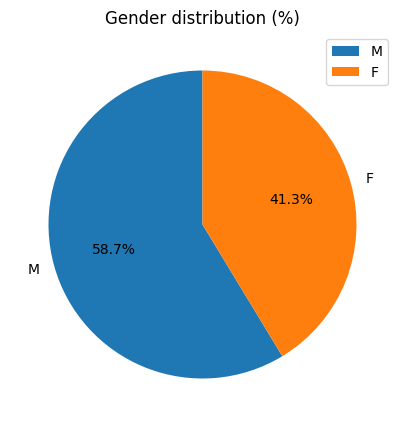

In [ ]:
plt.figure(figsize=(5,5))
counts = df['gender_label'].value_counts()
plt.pie(
    counts,
    autopct='%1.1f%%',
    startangle=90,
    labels=counts.index.tolist(),
)
plt.legend()
plt.title("Gender distribution (%)")
plt.show()

gender distribution but with cahr_len more than 20

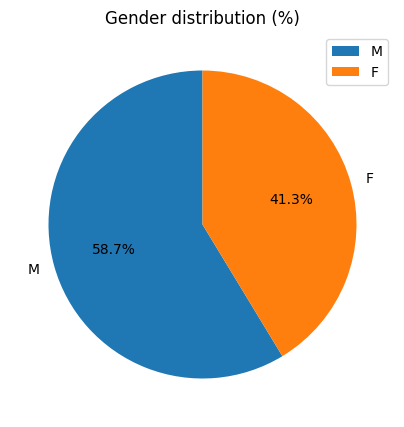

In [ ]:
plt.figure(figsize=(5,5))
counts = df.loc[df['char_len'] > 20, 'gender_label'].value_counts()
plt.pie(
    counts,
    autopct='%1.1f%%',
    startangle=90,
    labels=counts.index.tolist(),
)
plt.legend()
plt.title("Gender distribution (%)")
plt.show()

gender distribution but with token count more than 5

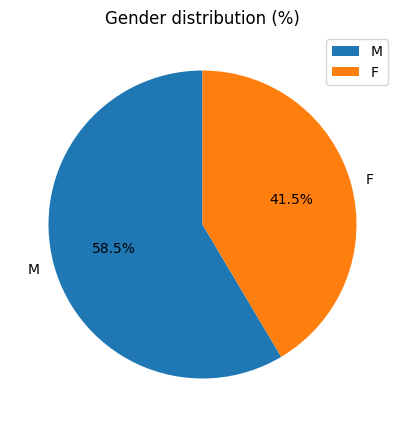

In [ ]:
plt.figure(figsize=(5,5))
counts = df.loc[df['tokens_count_clean'] > 5, 'gender_label'].value_counts()
plt.pie(
    counts,
    autopct='%1.1f%%',
    startangle=90,
    labels=counts.index.tolist(),
)
plt.legend()
plt.title("Gender distribution (%)")
plt.show()

## Summury statistics

In [ ]:
df.groupby('gender_label')[['char_len', 'tokens_count_clean']].agg(['mean', 'median', 'min', 'max', 'std'])

char_len                             tokens_count_clean  \
                    mean median min   max        std               mean   
gender_label                                                              
F             185.233354  191.0   4   950  87.872272          12.636410   
M             183.654583  187.0   4  1002  88.646828          12.555849   

                                       
             median min max       std  
gender_label                           
F              12.0   0  42  6.774357  
M              12.0   1  44  6.848573

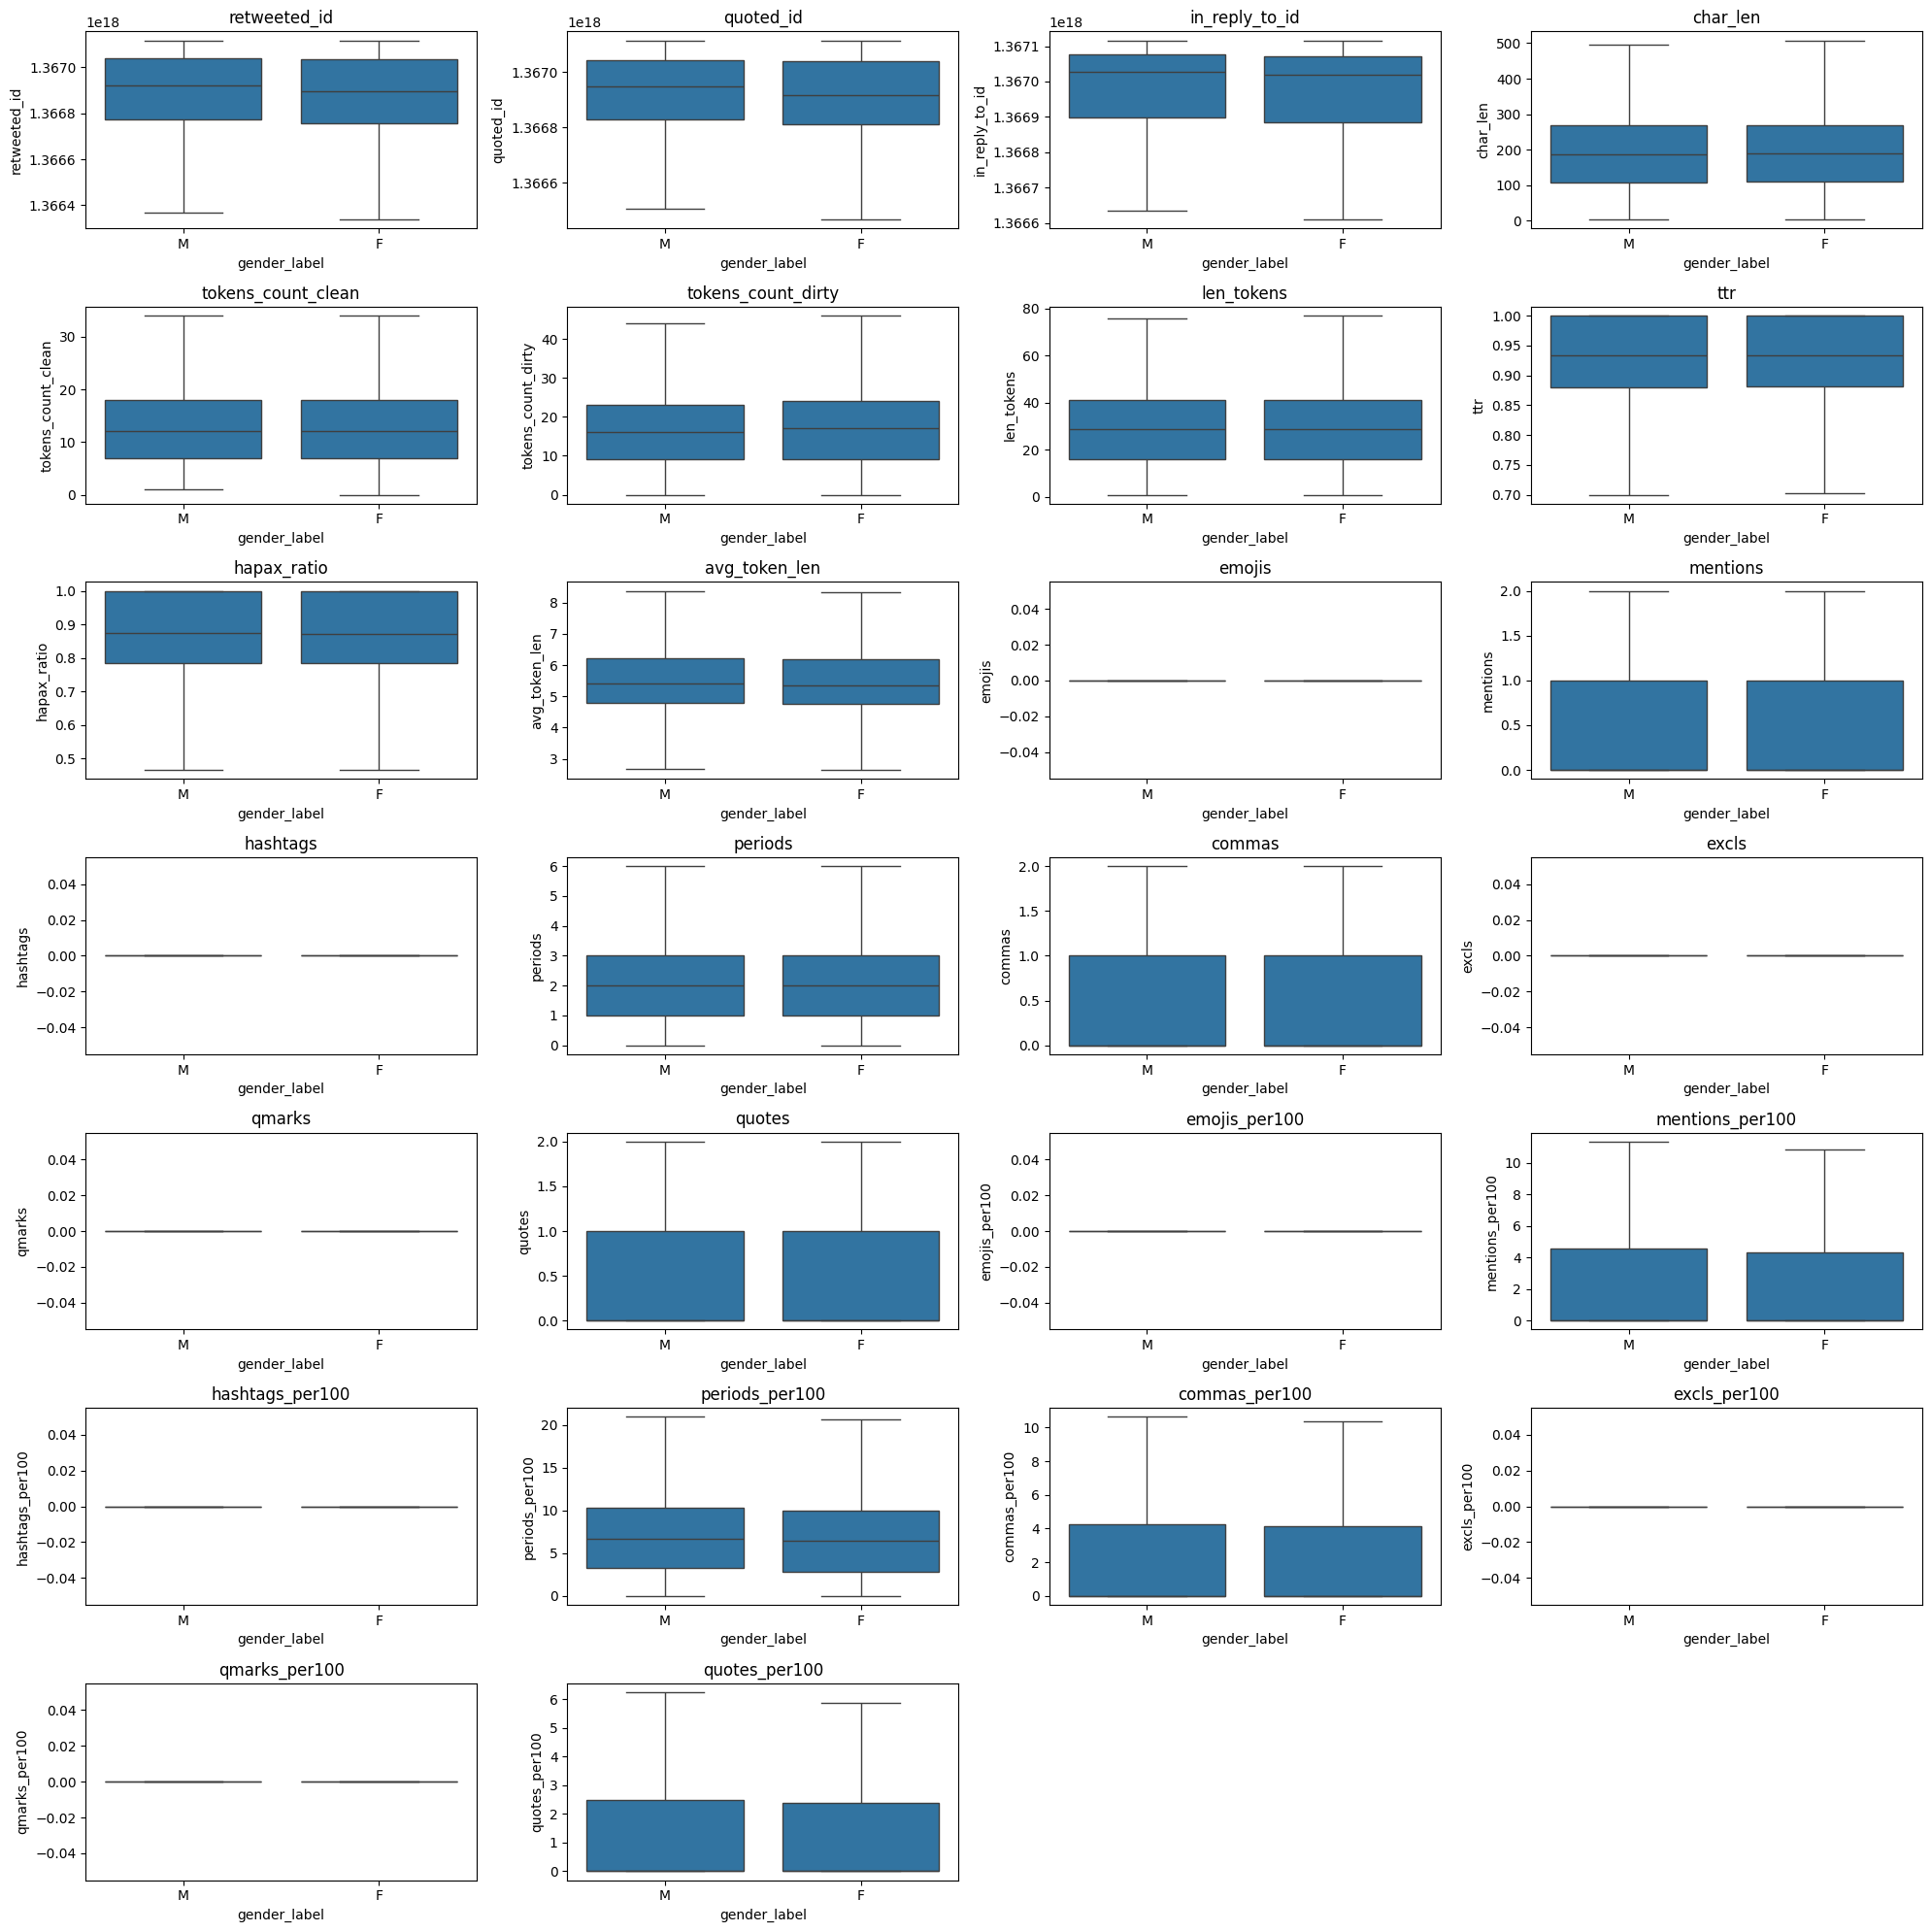

In [ ]:
cols = df.select_dtypes('number').columns.tolist()
fig, axes = plt.subplots(nrows=len(cols)//4 + 1, ncols=4, figsize=(20, 20))

for i, col in enumerate(cols):
    row = i // 4
    col_idx = i % 4
    sns.boxplot(data=df, x='gender_label', y=col, showfliers=False, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(col)

for i in range(len(cols), len(axes.flat)):
    fig.delaxes(axes.flat[i])

plt.tight_layout()
plt.show()

In [ ]:
df.groupby('gender_label').mean(True)

,retweeted_id,quoted_id,in_reply_to_id,char_len,tokens_count_clean,tokens_count_dirty,len_tokens,ttr,hapax_ratio,avg_token_len,...,qmarks,quotes,emojis_per100,mentions_per100,hashtags_per100,periods_per100,commas_per100,excls_per100,qmarks_per100,quotes_per100
gender_label,,,,,,,,,,,,,,,,,,,,,
F,1.365408e+18,1.364925e+18,1.366392e+18,185.233354,12.636410,16.800524,28.884261,0.925263,0.865755,5.606269,...,0.212019,0.558417,0.935333,3.254438,2.305159,7.987568,2.562463,1.385035,0.902923,1.944604
M,1.365132e+18,1.364760e+18,1.366640e+18,183.654583,12.555849,16.415029,28.454996,0.925790,0.867025,5.673069,...,0.202422,0.566584,0.714398,3.369059,2.271274,8.362906,2.577769,1.068351,0.876153,2.016309


In [ ]:
df['user_id'].value_counts().sort_values(ascending=False).head(10)

user_id
1364570479588089857    1
1272967375915151360    1
1188651251874979840    1
1357419690394587137    1
1365697740479598600    1
937569699654639617     1
1254469184731275264    1
568322556              1
1365188539248381956    1
62666453               1
Name: count, dtype: int64

In [ ]:
user_counts = df['user_id'].value_counts()
user_counts[user_counts != 1].shape[0]

0

mean number of tweets per user id

In [ ]:
df.groupby('gender_label')['user_id'].value_counts().groupby('gender_label').mean()

gender_label
F    1.0
M    1.0
Name: count, dtype: float64

## Lexical diversity statistics

We will use clear tokens without stopwords, emojis, mentions, hashtags, punctuation marks etc. Because we need to know lexical diversity

### Unique words

In [ ]:
all_words = set(chain.from_iterable(df['clean_tokens'].tolist()))
unique_word_count = len(all_words)
print(f"Total unique words: {unique_word_count}")

Total unique words: 55977


### Create gender df

In [ ]:
male_df = df[df['gender_label'] == 'M'].drop(columns=['gender_label'])
female_df = df[df['gender_label'] == 'F'].drop(columns=['gender_label'])

In [ ]:
male_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36330 entries, 41631 to 57099
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            36330 non-null  object 
 1   text                36330 non-null  object 
 2   user_id             36330 non-null  object 
 3   retweeted_id        10085 non-null  float64
 4   quoted_id           8166 non-null   float64
 5   in_reply_to_id      9843 non-null   float64
 6   clean_tokens        36330 non-null  object 
 7   joined_tokens       36330 non-null  object 
 8   dirty_tokens        36330 non-null  object 
 9   char_len            36330 non-null  int64  
 10  tokens_count_clean  36330 non-null  int64  
 11  tokens_count_dirty  36330 non-null  int64  
 12  len_tokens          36330 non-null  float64
 13  ttr                 36330 non-null  float64
 14  hapax_ratio         36330 non-null  float64
 15  avg_token_len       36330 non-null  float64
 16  emoji

In [ ]:
female_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25592 entries, 41076 to 129
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            25592 non-null  object 
 1   text                25592 non-null  object 
 2   user_id             25592 non-null  object 
 3   retweeted_id        8166 non-null   float64
 4   quoted_id           6074 non-null   float64
 5   in_reply_to_id      6387 non-null   float64
 6   clean_tokens        25592 non-null  object 
 7   joined_tokens       25592 non-null  object 
 8   dirty_tokens        25592 non-null  object 
 9   char_len            25592 non-null  int64  
 10  tokens_count_clean  25592 non-null  int64  
 11  tokens_count_dirty  25592 non-null  int64  
 12  len_tokens          25592 non-null  float64
 13  ttr                 25592 non-null  float64
 14  hapax_ratio         25592 non-null  float64
 15  avg_token_len       25592 non-null  float64
 16  emojis 

### Unique words used only by one gender

In [ ]:
all_words_male = Counter(chain.from_iterable(male_df['clean_tokens']))
all_words_female = Counter(chain.from_iterable(female_df['clean_tokens']))
male_only = {word: count for word, count in all_words_male.items() if word not in all_words_female}
female_only = {word: count for word, count in all_words_female.items() if word not in all_words_male}

print(f"Words used only by males: {len(male_only)}. {list(male_only)[:20]}")
print(f"Words used only by females: {len(female_only)}. {list(female_only)[:20]}")

Words used only by males: 22644. ['promsied', 'roti', 'kapda', 'makan', 'bre', 'sochna', 'hy', 'hote', 'rhe', 'mehngai', 'upar', 'rhi', 'kaise', 'aacha', 'beti', 'apne', 'maa', 'aankho', 'mrte', 'chor']
Words used only by females: 13793. ['heena', 'rajput', 'lekar', 'kuchh', 'banaiye', 'bahot', 'shikar', 'rahe', 'berozgari', 'dhanywaad', 'pomy', 'kundal', 'handcream', 'shampooprotein', 'ylang', 'ck', 'blossom', 'rj', 'jasmine', 'chaser']


In [ ]:
all_words_male.most_common(20)


[('people', 3971),
 ('just', 2475),
 ('dont', 2097),
 ('like', 2071),
 ('new', 1769),
 ('time', 1625),
 ('year', 1604),
 ('need', 1499),
 ('health', 1393),
 ('im', 1330),
 ('know', 1250),
 ('treatment', 1214),
 ('today', 1200),
 ('good', 1167),
 ('mask', 1133),
 ('help', 1116),
 ('think', 1102),
 ('going', 1089),
 ('work', 1083),
 ('day', 1077)]

In [ ]:
all_words_female.most_common(20)

[('people', 2969),
 ('just', 1863),
 ('dont', 1488),
 ('like', 1458),
 ('im', 1391),
 ('new', 1193),
 ('time', 1166),
 ('year', 1151),
 ('need', 1135),
 ('health', 1105),
 ('know', 971),
 ('today', 948),
 ('mask', 921),
 ('help', 921),
 ('got', 863),
 ('treatment', 856),
 ('work', 853),
 ('good', 810),
 ('going', 806),
 ('getting', 791)]

### Histplot

just to see distribution of unique words used

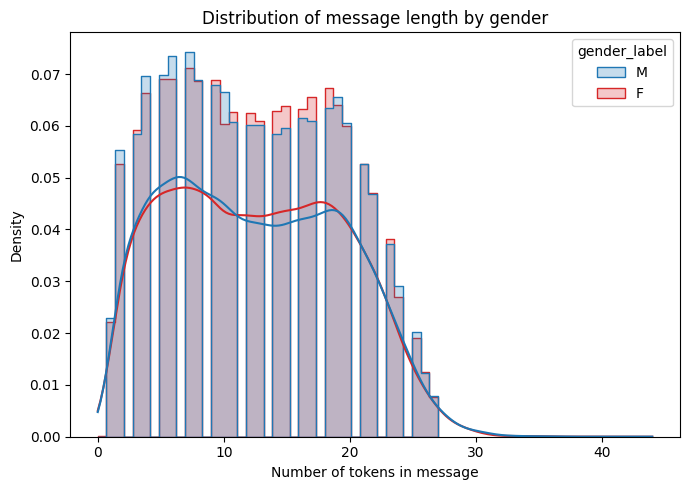

In [ ]:
plt.figure(figsize=(7,5))
sns.histplot(
    data=df,
    x="tokens_count_clean",
    hue="gender_label",
    bins=np.linspace(0, np.percentile(df["tokens_count_clean"], 99), 40),
    element="step",
    stat="density",
    common_norm=False,
    kde=True,
    palette={"M":"tab:blue", "F":"tab:red"}
)
plt.xlabel("Number of tokens in message")
plt.ylabel("Density")
plt.title("Distribution of message length by gender")
plt.tight_layout()
plt.show()

### Boxplot

for token count by gender

<Axes: xlabel='gender_label', ylabel='tokens_count_clean'>

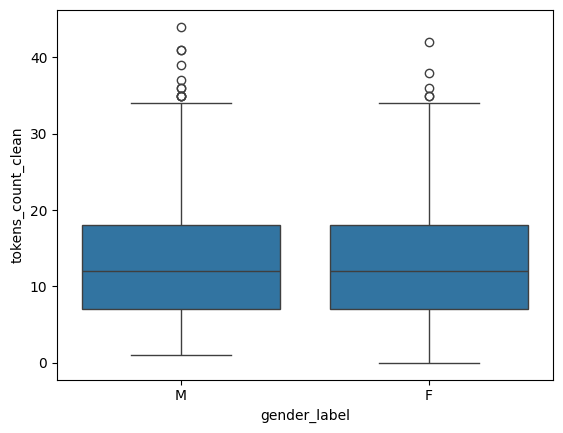

In [ ]:
sns.boxplot(x='gender_label', y='tokens_count_clean', data=df)

for char len by gender

<Axes: xlabel='gender_label', ylabel='char_len'>

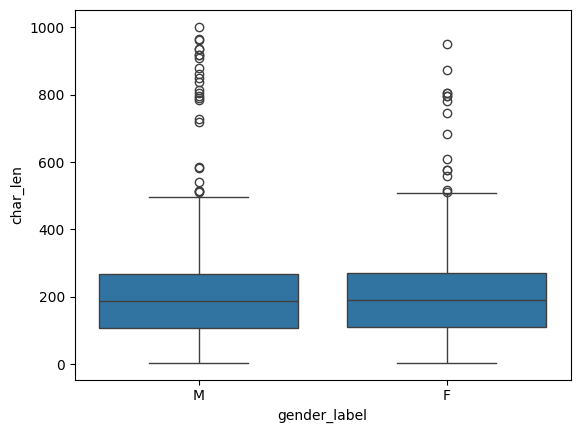

In [ ]:
sns.boxplot(x='gender_label', y='char_len', data=df)

### Scatter plot

the most used words by gender

In [ ]:
male_word_freq = Counter(chain.from_iterable(male_df['clean_tokens']))
female_word_freq = Counter(chain.from_iterable(female_df['clean_tokens']))

In [ ]:
top_n = 50
male_top = male_word_freq.most_common(top_n)
female_top = female_word_freq.most_common(top_n)
print("Top {} male words: {}".format(top_n, male_top))
print("Top {} female words: {}".format(top_n, female_top))

Top 50 male words: [('people', 3971), ('just', 2475), ('dont', 2097), ('like', 2071), ('new', 1769), ('time', 1625), ('year', 1604), ('need', 1499), ('health', 1393), ('im', 1330), ('know', 1250), ('treatment', 1214), ('today', 1200), ('good', 1167), ('mask', 1133), ('help', 1116), ('think', 1102), ('going', 1089), ('work', 1083), ('day', 1077), ('government', 1048), ('got', 1043), ('texas', 1010), ('make', 1002), ('world', 970), ('want', 959), ('getting', 938), ('cases', 906), ('deaths', 860), ('news', 841), ('support', 824), ('did', 818), ('said', 815), ('right', 810), ('way', 791), ('country', 780), ('state', 776), ('really', 771), ('end', 769), ('great', 767), ('say', 760), ('thats', 754), ('uk', 740), ('public', 729), ('march', 724), ('care', 717), ('years', 694), ('masks', 681), ('social', 668), ('says', 667)]
Top 50 female words: [('people', 2969), ('just', 1863), ('dont', 1488), ('like', 1458), ('im', 1391), ('new', 1193), ('time', 1166), ('year', 1151), ('need', 1135), ('healt

In [ ]:
least_n = 10
male_least = male_word_freq.most_common()[:-least_n-1:-1]
female_least = female_word_freq.most_common()[:-least_n-1:-1]
print("Least {} male words: {}".format(least_n, male_least))
print("Least {} female words: {}".format(least_n, female_least))

Least 10 male words: [('toccaareee', 1), ('anjay', 1), ('phostel', 1), ('butcovid', 1), ('alch', 1), ('numpty', 1), ('selfdefense', 1), ('lawan', 1), ('slain', 1), ('humm', 1)]
Least 10 female words: [('coment', 1), ('suspens', 1), ('thissssss', 1), ('millionvaccinestodayalone', 1), ('briliant', 1), ('mortes', 1), ('seconded', 1), ('bsting', 1), ('mediamanagerspersonalitiesreceivefirstdoseofcovidvaccine', 1), ('cancelem', 1)]


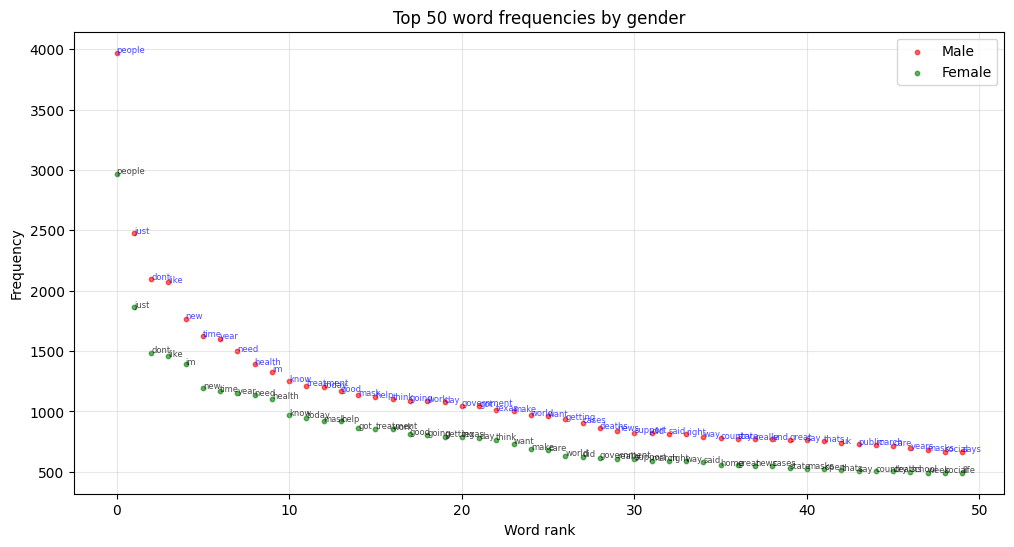

In [ ]:
plt.figure(figsize=(12, 6))

male_words_list = [word for word, count in male_top]
male_counts = [count for word, count in male_top]
female_words_list = [word for word, count in female_top]
female_counts = [count for word, count in female_top]

plt.scatter(range(len(male_top)), male_counts, alpha=0.6, s=10, label='Male', color='red')
plt.scatter(range(len(female_top)), female_counts, alpha=0.6, s=10, label='Female', color='green')

for i in range(top_n):
    plt.annotate(male_words_list[i], (i, male_counts[i]), fontsize=6, alpha=0.7, color='blue')
    plt.annotate(female_words_list[i], (i, female_counts[i]), fontsize=6, alpha=0.7, color='black')

plt.title(f"Top {top_n} word frequencies by gender")
plt.xlabel("Word rank")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### qq-plot

shows us what word used with bigger probability by which gender

only words that are presented in both genders

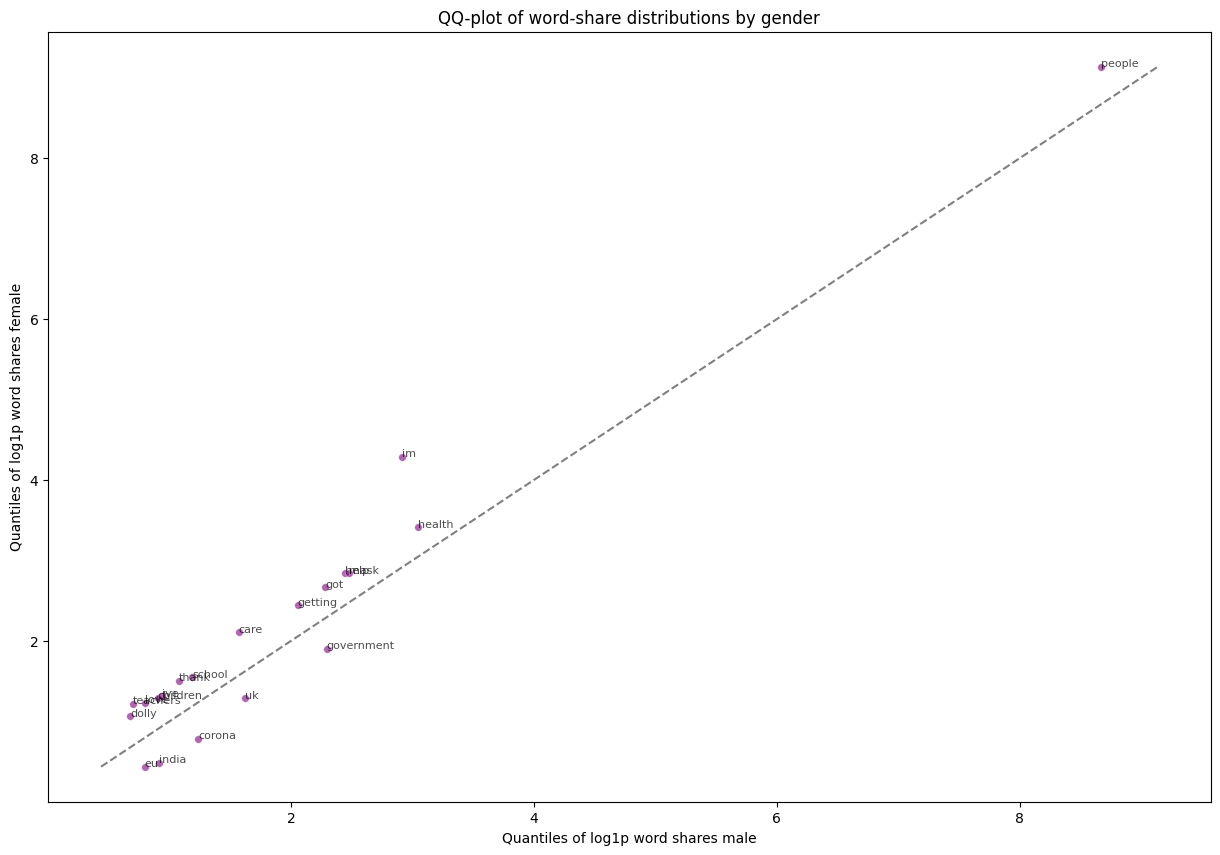

In [ ]:
male_total = sum(male_word_freq.values())
female_total = sum(female_word_freq.values())
common_words = set(male_word_freq.keys()) & set(female_word_freq.keys())
words_plot = pd.DataFrame([
    {
        'word': word,
        'p_m': male_word_freq[word] / male_total,
        'p_f': female_word_freq[word] / female_total
    }
    for word in common_words
])

words_plot['male_q'] = words_plot['p_m'].apply(np.log1p).apply(lambda x: x * 10**3)
words_plot['female_q'] = words_plot['p_f'].apply(np.log1p).apply(lambda x: x * 10**3)
words_plot['diff'] = np.abs(words_plot['male_q'] - words_plot['female_q'])

top_20_words = words_plot.nlargest(20, 'diff')

plt.figure(figsize=(15,10))
sns.scatterplot(data=top_20_words, x="male_q", y="female_q", color="purple", alpha=0.6, s=30)
lims = [top_20_words[['male_q', 'female_q']].min().min(), top_20_words[['male_q', 'female_q']].max().max()]
sns.lineplot(x=lims, y=lims, color="gray", linestyle="--")
plt.xlabel("Quantiles of log1p word shares male")
plt.ylabel("Quantiles of log1p word shares female")
plt.title("QQ-plot of word-share distributions by gender")

for idx, row in top_20_words.iterrows():
    x_val = row['male_q']
    y_val = row['female_q']
    word = row['word']
    plt.annotate(word, (x_val, y_val), fontsize=8, alpha=0.7)

plt.show()

Conclusion

We dont use words that was used only by one gender.

## Stylistic differences statistics

In [ ]:
total_tokens = df['tokens_count_clean'].sum()
male_tokens = male_df['tokens_count_clean'].sum()
female_tokens = female_df['tokens_count_clean'].sum()

print(f"Total tokens in dataset: {total_tokens:,}")
print(f"Male tokens: {male_tokens:,}")
print(f"Female tokens: {female_tokens:,}")

Total tokens in dataset: 779,545
Male tokens: 456,154
Female tokens: 323,391


### char n-grams

In [ ]:
vect_test = CountVectorizer(
    analyzer='char',
    ngram_range=(3,3),
    lowercase=True,
    min_df=10
)
x_test = vect_test.fit_transform(df['clean_tokens'].apply(lambda tokens: ' '.join(tokens)))
total_ngrams = len(vect_test.get_feature_names_out())
print(f"Total n-grams with min_df=10: {total_ngrams:,}")

Total n-grams with min_df=10: 6,311


we will use max features to limit number of n-grams

In [ ]:
vect = CountVectorizer(
    analyzer='char',
    ngram_range=(3,5),
    lowercase=True,
    min_df=10,
    max_features=int(total_ngrams*0.7)
)

x_char: np.ndarray = vect.fit_transform(df['clean_tokens'].apply(lambda tokens: '_'.join(tokens)))  # type: ignore
feats = np.array(vect.get_feature_names_out())
freq = {}
for g in df['gender_label'].unique():
    subX = x_char[df['gender_label'].values == g]
    counts = np.asarray(subX.sum(axis=0)).ravel()
    total = counts.sum()
    freq[g] = (counts / max(total, 1)) * 10000

out = pd.DataFrame(freq, index=feats)
out['total_count'] = np.asarray(x_char.sum(axis=0)).ravel()
out.index.name = f'char_3_5_ngram'
out.head()

,M,F,total_count
char_3_5_ngram,,,
_ab,2.693534,2.773026,2424
_ac,4.944242,5.002268,4417
_acc,1.952283,2.050687,1772
_acce,0.916456,1.079451,875
_act,2.289215,2.240064,2017


In [ ]:
top_n = 20

male_top = out.nlargest(top_n, 'M')[['M', 'total_count']]
female_top = out.nlargest(top_n, 'F')[['F', 'total_count']]

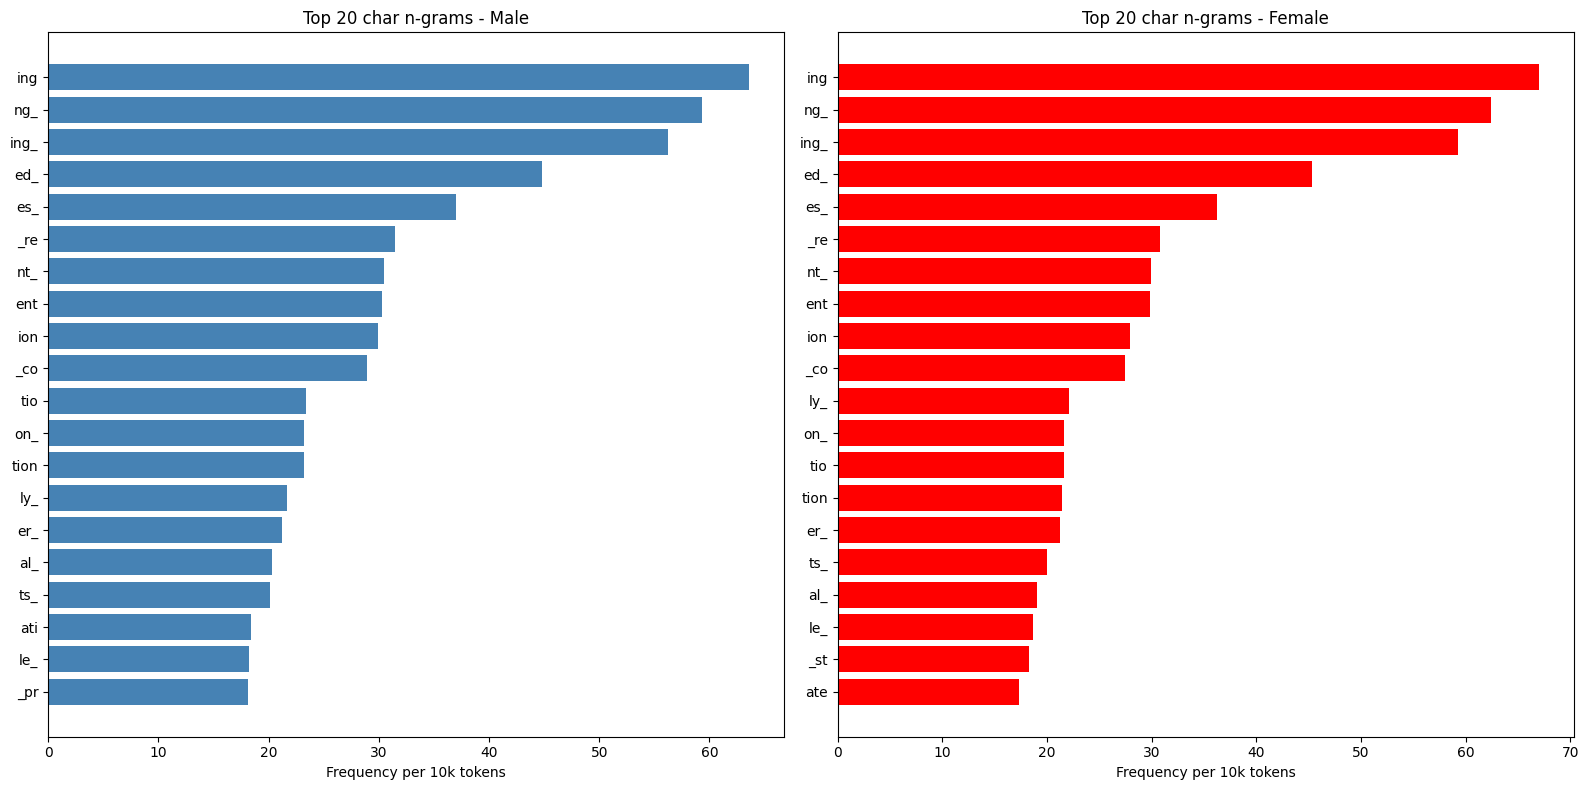

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].barh(range(len(male_top)), male_top['M'], color='steelblue')
axes[0].set_yticks(range(len(male_top)))
axes[0].set_yticklabels(male_top.index)
axes[0].set_xlabel('Frequency per 10k tokens')
axes[0].set_title(f'Top {top_n} char n-grams - Male')
axes[0].invert_yaxis()

axes[1].barh(range(len(female_top)), female_top['F'], color='red')
axes[1].set_yticks(range(len(female_top)))
axes[1].set_yticklabels(female_top.index)
axes[1].set_xlabel('Frequency per 10k tokens')
axes[1].set_title(f'Top {top_n} char n-grams - Female')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
d = out[out['total_count'] > 150].copy()
A = d.get('M', 0.0).astype(float)  # type: ignore
B = d.get('F', 0.0).astype(float)  # type: ignore
d['log_ratio'] = np.log((A + 0.5) / (B + 0.5))
d['log_ratio_abs'] = d['log_ratio'].abs()
d.head()

,M,F,total_count,log_ratio,log_ratio_abs
char_3_5_ngram,,,,,
_ab,2.693534,2.773026,2424,-0.024587,0.024587
_ac,4.944242,5.002268,4417,-0.010602,0.010602
_acc,1.952283,2.050687,1772,-0.039343,0.039343
_acce,0.916456,1.079451,875,-0.108919,0.108919
_act,2.289215,2.240064,2017,0.017779,0.017779


Text(0.5, 1.0, 'Word n-grams: F (red) vs M (blue)')

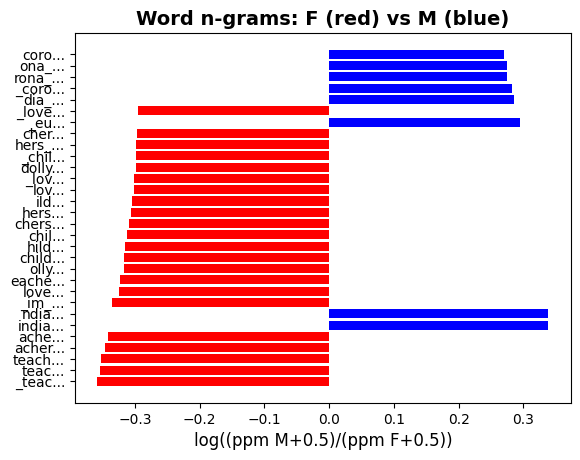

In [ ]:
sel = d.sort_values('log_ratio_abs', ascending=False).head(30)
index = sel.index.str[:20] + '...'
index = index.tolist()
sel['color'] = ['blue' if val > 0 else 'red' for val in sel['log_ratio']]
plt.barh(range(len(sel)), sel['log_ratio'], color=sel['color'].tolist())
plt.yticks(range(len(sel)), index)

plt.xlabel(f'log((ppm M+0.5)/(ppm F+0.5))', fontsize=12)
plt.title(f'Word n-grams: F (red) vs M (blue)', fontsize=14, fontweight='bold')

### word n-grams

check how much ngrams for 3 grams we can make with min_df=10

In [ ]:
vect_test = CountVectorizer(
    analyzer='word',
    ngram_range=(3,3),
    min_df=10,
)
x_word = vect_test.fit_transform(df['dirty_tokens'].apply(lambda tokens: ' '.join(tokens)))
total_ngrams = len(vect_test.get_feature_names_out())
print(f"Total n-grams with min_df=10: {total_ngrams:,}")

Total n-grams with min_df=10: 1,900


In [ ]:
vect = CountVectorizer(
    analyzer='word',
    ngram_range=(3,5),
    min_df=10,
    max_features=int(total_ngrams*0.7)
)

x_word: np.ndarray = vect.fit_transform(df['dirty_tokens'].apply(lambda tokens: ' '.join(tokens)))  # type: ignore
feats = np.array(vect.get_feature_names_out())

freq_M = []
freq_F = []
count_M = []
count_F = []

for g in df['gender_label'].unique():
    subX = x_word[df['gender_label'].values == g]
    counts = np.asarray(subX.sum(axis=0)).ravel()
    total = counts.sum()
    freq_per_10k = (counts / max(total, 1)) * 10000
    
    if g == 'M':
        freq_M = freq_per_10k
        count_M = counts
    else:
        freq_F = freq_per_10k
        count_F = counts

word_gram_freq = pd.DataFrame({
    'M': freq_M,
    'F': freq_F,
    'M_count': count_M,
    'F_count': count_F
}, index=feats)

word_gram_freq['total_count'] = np.asarray(x_word.sum(axis=0)).ravel()
word_gram_freq.index.name = f'word_3_5_ngram'
word_gram_freq.head()

,M,F,M_count,F_count,total_count
word_3_5_ngram,,,,,
000 doses of,14.734217,13.156933,26,18,44
000 people have,6.800408,1.461881,12,2,14
000 people in,3.966905,5.847526,7,8,15
03 03 2021,4.533605,3.654704,8,5,13
10 years of,5.667007,8.771289,10,12,22


top char ngrams for each gender 

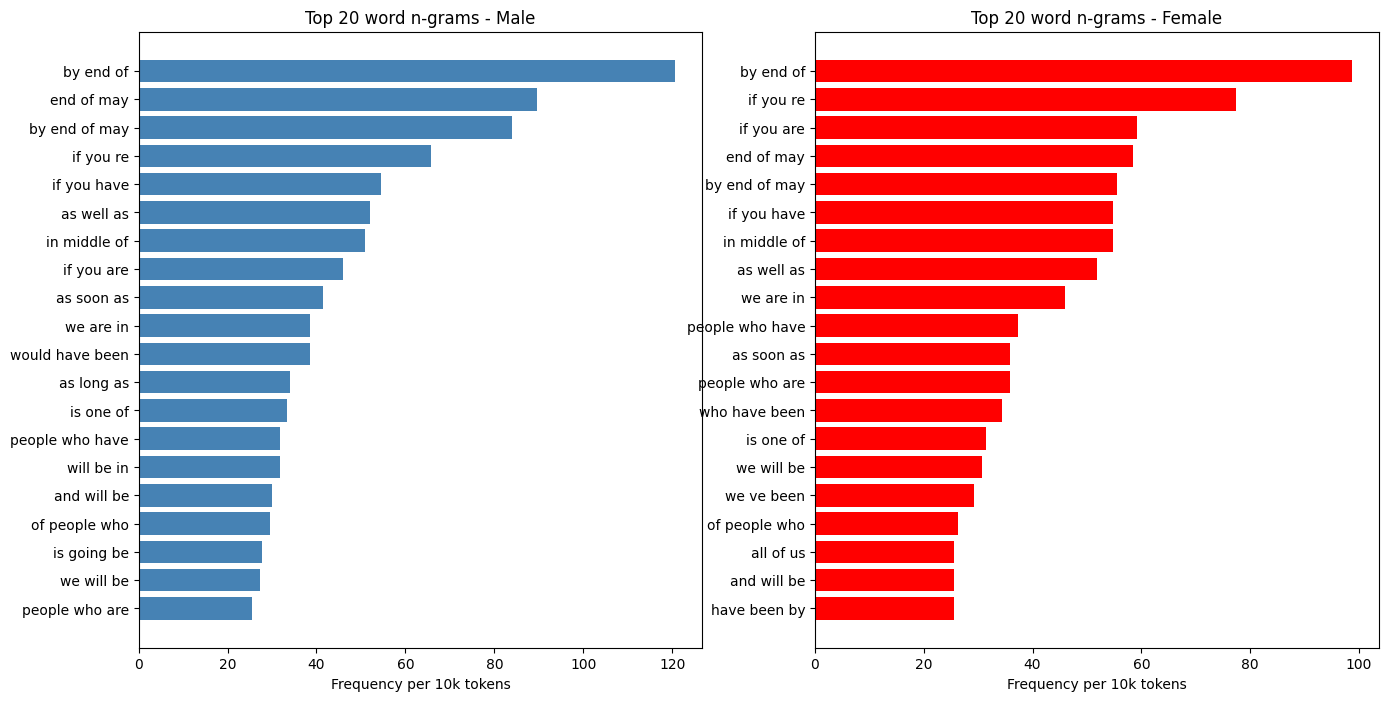

In [ ]:
top_n = 20

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

male_top = word_gram_freq[word_gram_freq['M'] > 0].nlargest(top_n, 'M')[['M', 'total_count']]
axes[0].barh(range(len(male_top)), male_top['M'], color='steelblue')
axes[0].set_yticks(range(len(male_top)))
axes[0].set_yticklabels(male_top.index)
axes[0].set_xlabel('Frequency per 10k tokens')
axes[0].set_title(f'Top {top_n} word n-grams - Male')
axes[0].invert_yaxis()

female_top = word_gram_freq[word_gram_freq['F'] > 0].nlargest(top_n, 'F')[['F', 'total_count']]
axes[1].barh(range(len(female_top)), female_top['F'], color='red')
axes[1].set_yticks(range(len(female_top)))
axes[1].set_yticklabels(female_top.index)
axes[1].set_xlabel('Frequency per 10k tokens')
axes[1].set_title(f'Top {top_n} word n-grams - Female')
axes[1].invert_yaxis()

Analyzing ngrams Which are more characteristic of each gender using log ratio

In [ ]:
d = out.copy()
A = d.get('M', 0.0).astype(float)  # type: ignore
B = d.get('F', 0.0).astype(float)  # type: ignore
d['log_ratio'] = np.log((A + 0.5) / (B + 0.5))
d['log_ratio_abs'] = d['log_ratio'].abs()

Text(0.5, 1.0, 'Word n-grams: F (red) vs M (blue)')

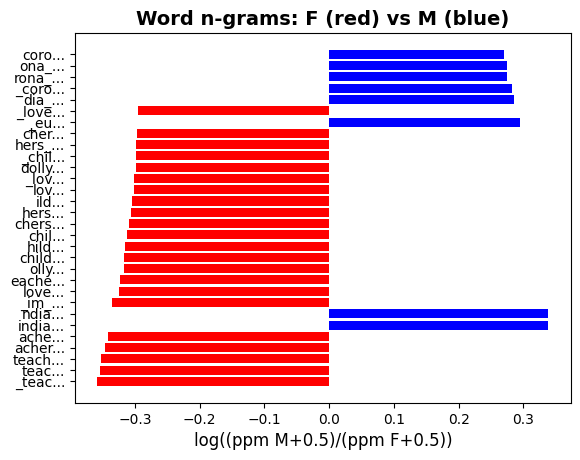

In [ ]:
sel = d.sort_values('log_ratio_abs', ascending=False).head(30)
index = sel.index.str[:20] + '...'
index = index.tolist()
sel['color'] = ['blue' if val > 0 else 'red' for val in sel['log_ratio']]
plt.barh(range(len(sel)), sel['log_ratio'], color=sel['color'].tolist())
plt.yticks(range(len(sel)), index)

plt.xlabel(f'log((ppm M+0.5)/(ppm F+0.5))', fontsize=12)
plt.title(f'Word n-grams: F (red) vs M (blue)', fontsize=14, fontweight='bold')

### word skip ngrams

In [ ]:
def make_skip_analyzer(n: tuple[int,int], k: int):
    def analyzer(text: str| list[str]):
        if isinstance(text, list):
            toks = text
        elif isinstance(text, str):
            toks = text.split()
        else:
            raise ValueError("Input should be a string or a list of strings.")
        for i in range(n[0], n[1] + 1):
            for g in nltk.skipgrams(toks, n=i, k=k):
                yield " ".join(g)
    return analyzer


In [ ]:
vect_test = CountVectorizer(
    analyzer=make_skip_analyzer(n=(2,2), k=1),
    min_df=10,
)
x_word = vect_test.fit_transform(df['dirty_tokens'].apply(lambda tokens: ' '.join(tokens)))
total_skip_ngrams = len(vect_test.get_feature_names_out())
print(f"Total skip n-grams with min_df=10: {total_skip_ngrams:,}")

Total skip n-grams with min_df=10: 16,923


In [ ]:
vect_skip = CountVectorizer(
    analyzer=make_skip_analyzer(n=(3,4), k=2),
    min_df=10,
    max_features=int(total_skip_ngrams*0.7)
)
x_skip: np.ndarray = vect_skip.fit_transform(df['dirty_tokens']) # type: ignore
feats = np.array(vect_skip.get_feature_names_out())
freq_M = []
freq_F = []
count_M = []
count_F = []
for g in df['gender_label'].unique():
    subX = x_skip[df['gender_label'].values == g]
    counts = np.asarray(subX.sum(axis=0)).ravel()
    total = counts.sum()
    freq_per_10k = (counts / max(total, 1)) * 10000
    if g == 'M':
        freq_M = freq_per_10k
        count_M = counts
    else:
        freq_F = freq_per_10k
        count_F = counts
word_skip_gram_freq = pd.DataFrame({
    'M': freq_M,
    'F': freq_F,
    'M_count': count_M,
    'F_count': count_F
}, index=feats)
word_skip_gram_freq['total_count'] = np.asarray(x_skip.sum(axis=0)).ravel()
word_skip_gram_freq.index.name = f'skip_word_3_5_ngrams_skip_1'
word_skip_gram_freq.head()

,M,F,M_count,F_count,total_count
skip_word_3_5_ngrams_skip_1,,,,,
$1.9 relief bill,0.431090,0.487843,6,5,11
$15 minimum wage,0.934029,0.487843,13,5,18
- - -,6.250808,3.122195,87,32,119
- - 1300,0.790332,0.000000,11,0,11
- - 1300 Russia,0.790332,0.000000,11,0,11


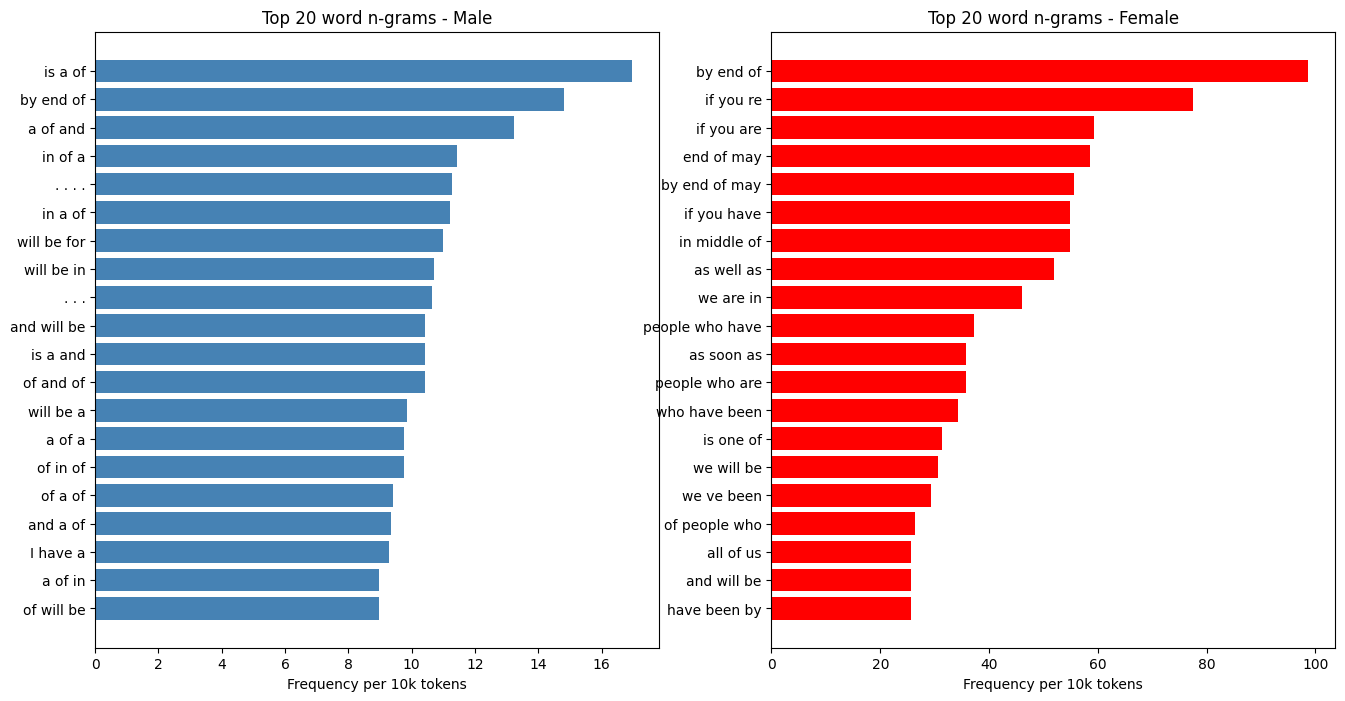

In [ ]:
top_n = 20

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

male_top = word_skip_gram_freq[word_skip_gram_freq['M'] > 0].nlargest(top_n, 'M')[['M', 'total_count']]
axes[0].barh(range(len(male_top)), male_top['M'], color='steelblue')
axes[0].set_yticks(range(len(male_top)))
axes[0].set_yticklabels(male_top.index)
axes[0].set_xlabel('Frequency per 10k tokens')
axes[0].set_title(f'Top {top_n} word n-grams - Male')
axes[0].invert_yaxis()

female_top = word_gram_freq[word_gram_freq['F'] > 0].nlargest(top_n, 'F')[['F', 'total_count']]
axes[1].barh(range(len(female_top)), female_top['F'], color='red')
axes[1].set_yticks(range(len(female_top)))
axes[1].set_yticklabels(female_top.index)
axes[1].set_xlabel('Frequency per 10k tokens')
axes[1].set_title(f'Top {top_n} word n-grams - Female')
axes[1].invert_yaxis()

# Statistics tests by groups

#### mann whitney u test for numerical features

Nonparametric tests for numerical characteristics Mann–Whitney U

Null hypothesis H0: the distributions of the characteristic in groups M and F are identical.

For each numerical column, calculates the U statistic and p-value, and marks significant characteristics at p < 0.05.

In [ ]:
numerical_features = df.select_dtypes(include=['number']).columns.tolist()

mann_whitney_results = []
for feature in numerical_features:
    male_values = male_df[feature].dropna()
    female_values = female_df[feature].dropna()
    
    statistic, p_value = stats.mannwhitneyu(male_values, female_values, alternative='two-sided')
    
    mann_whitney_results.append({
        'feature': feature,
        'statistic': statistic,
        'p_value': round(p_value, 4),
        'significant': p_value < 0.05
    })
    
mann_whitney_df = pd.DataFrame(mann_whitney_results)
mann_whitney_df = mann_whitney_df.sort_values(['p_value', 'statistic'], ascending=[True, False])
print(mann_whitney_df.to_string(index=False))

           feature   statistic  p_value  significant
     avg_token_len 477124844.5   0.0000         True
    periods_per100 475042260.0   0.0000         True
tokens_count_dirty 453436374.0   0.0000         True
     emojis_per100 450927742.0   0.0000         True
            emojis 450849638.5   0.0000         True
             excls 447651735.5   0.0000         True
      excls_per100 447578276.5   0.0000         True
      retweeted_id  42818111.0   0.0000         True
    in_reply_to_id  32874848.5   0.0000         True
         quoted_id  25797462.5   0.0000         True
          hashtags 458647302.0   0.0001         True
        len_tokens 456591882.5   0.0002         True
   hashtags_per100 459463566.5   0.0009         True
     quotes_per100 469296147.0   0.0117         True
          char_len 459362094.5   0.0118         True
            quotes 468548861.5   0.0359         True
       hapax_ratio 468727114.5   0.0747        False
tokens_count_clean 461185840.5   0.0915       

#### chi square test for categorical features

Categorical comparisons of words using the Chi-square test whether the use of a particular word depends 
on gender

Null hypothesis H0 the use of w does not depend on gender

p < 0.05 differences in usage are statistically significant

Cramer V is used to assess the strength of the relationship between word usage and user gender.

In [ ]:
top_n_tokens = 100
male_top_tokens = male_word_freq.most_common(top_n_tokens)
female_top_tokens = female_word_freq.most_common(top_n_tokens)

all_top_words = set([word for word, _ in male_top_tokens] + [word for word, _ in female_top_tokens])

chi2_results = []
for word in all_top_words:
    male_count = male_word_freq[word]
    female_count = female_word_freq[word]
    
    contingency_table = np.array([
        [male_count, male_tokens - male_count],
        [female_count, female_tokens - female_count]
    ])
    
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    cramers_v = stats.contingency.association(contingency_table, method='cramer')
    
    chi2_results.append({
        'word': word,
        'male_count': male_count,
        'female_count': female_count,
        'chi2': chi2,
        'p_value': p_value, # type: ignore
        'cramers_v': cramers_v,
        'significant': p_value < 0.05 # type: ignore
    })
chi2_df = pd.DataFrame(chi2_results)
chi2_df = chi2_df.sort_values(['p_value', 'chi2'], ascending=[True, False])
chi2_df['p_value'] = chi2_df['p_value'].round(4)
print(chi2_df[chi2_df['significant'] == True].to_string(index=False))

      word  male_count  female_count       chi2  p_value  cramers_v  significant
        im        1330          1391 104.053157   0.0000   0.011575         True
  teachers         320           395  55.254764   0.0000   0.008462         True
      love         363           399  36.731195   0.0000   0.006906         True
    corona         564           254  36.289989   0.0000   0.006863         True
     dolly         309           345  33.770925   0.0000   0.006627         True
      care         717           682  30.169709   0.0000   0.006252         True
     thank         493           487  26.903689   0.0000   0.005911         True
  children         412           417  26.214260   0.0000   0.005839         True
       ive         430           424  23.139025   0.0000   0.005488         True
      feel         358           357  20.681156   0.0000   0.005194         True
    school         541           502  18.729074   0.0000   0.004937         True
       big         493      

## statistic for word n grams

Categorical comparisons of words using the Chi-square test whether the use of a particular ngram depends 
on gender

Null hypothesis H0 the use of w does not depend on gender

p < 0.05 differences in usage are statistically significant

Cramer V is used to assess the strength of the relationship between word usage and user gender.